In [2]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from tqdm import tqdm
import gc
import datetime
from dateutil.parser import parse

In [3]:
train = pd.read_csv('datas/train.csv',encoding='gb18030')

test = pd.read_csv('datas/testA.csv',encoding='gb18030')

def make_feat(train,test):

    train_id = train.id.values.copy()

    test_id = test.id.values.copy()

    data = pd.concat([train,test])

    data['性别'] = data['性别'].map({'男':1,'女':0})

    data['体检日期'] = (pd.to_datetime(data['体检日期']) - parse('2016-10-09')).dt.days

    

#    data.fillna(data.median(axis=0),inplace=True)

    train_feat = data[data.id.isin(train_id)]

    test_feat = data[data.id.isin(test_id)]

    

    return train_feat,test_feat



In [4]:
train_df,test_df = make_feat(train,test)

print('Remove missing data fields ...')

missing_perc_thresh = 0.98

exclude_missing = []

num_rows = train_df.shape[0]

for c in train_df.columns:

    num_missing = train_df[c].isnull().sum()

    if num_missing == 0:

        continue

    missing_frac = num_missing / float(num_rows)

    if missing_frac > missing_perc_thresh:

        exclude_missing.append(c)

print("We exclude: %s" % len(exclude_missing))

del num_rows, missing_perc_thresh

gc.collect();

Remove missing data fields ...
We exclude: 0


In [6]:
print ("Remove features with one unique value !!")

exclude_unique = []

for c in train_df.columns:

    num_uniques = len(train_df[c].unique())

    if train_df[c].isnull().sum() != 0:

        num_uniques -= 1

    if num_uniques == 1:

        exclude_unique.append(c)

print("We exclude: %s" % len(exclude_unique))

Remove features with one unique value !!
We exclude: 0


In [7]:
print ("Define training features !!")

exclude_other = ['id','血糖','乙肝表面抗原', '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体']

train_features = []

for c in train_df.columns:

    if c not in exclude_missing and c not in exclude_other and c not in exclude_unique:

        train_features.append(c)

print("We use these for training: %s" % len(train_features))

print ("Define categorial features !!")

Define training features !!
We use these for training: 35
Define categorial features !!


In [9]:
cat_feature_inds = []

cat_unique_thresh = 10

for i, c in enumerate(train_features):

    num_uniques = len(train_df[c].unique())

    if num_uniques < cat_unique_thresh:

        cat_feature_inds.append(i)

        

print("Cat features are: %s" % [train_features[ind] for ind in cat_feature_inds])

Cat features are: ['性别']


In [15]:
print ("Replacing NaN values by -999 !!")

train_df.fillna(-999, inplace=True)

test_df.fillna(-999, inplace=True)

Replacing NaN values by -999 !!


In [16]:
train_df

,*r-谷氨酰基转换酶,*丙氨酸氨基转换酶,*天门冬氨酸氨基转换酶,*总蛋白,*球蛋白,*碱性磷酸酶,id,中性粒细胞%,乙肝e抗体,乙肝e抗原,...,红细胞平均血红蛋白量,红细胞计数,肌酐,血小板体积分布宽度,血小板平均体积,血小板比积,血小板计数,血糖,血红蛋白,高密度脂蛋白胆固醇
0,20.23,23.10,24.96,76.88,27.28,99.59,1,54.1,-999.00,-999.00,...,31.9,5.21,77.25,17.4,9.9,0.164,166.0,6.06,166.1,1.37
1,79.00,36.25,24.57,79.43,31.67,67.21,2,52.0,-999.00,-999.00,...,29.9,5.21,87.12,10.3,9.2,0.260,277.0,5.39,156.0,0.93
2,38.17,15.23,20.82,86.23,38.23,63.69,3,48.1,1.37,0.01,...,31.3,4.76,78.19,16.6,8.3,0.199,241.0,5.59,148.8,1.64
3,20.22,10.59,14.99,70.98,26.96,74.08,4,41.7,-999.00,-999.00,...,31.9,4.29,61.46,10.8,10.3,0.260,252.0,4.30,137.0,1.43
4,22.72,14.78,20.07,78.05,36.22,75.79,5,56.6,-999.00,-999.00,...,20.6,5.15,-999.00,14.0,11.1,0.350,316.0,5.42,106.0,1.27
5,23.35,22.59,23.72,76.46,30.61,81.23,6,42.9,1.22,0.01,...,30.4,4.64,66.66,17.0,8.5,0.211,249.0,5.97,141.3,1.81
6,65.42,25.53,24.97,80.82,34.42,109.03,7,52.9,-999.00,-999.00,...,28.5,6.03,95.98,13.3,10.8,0.270,246.0,5.11,172.0,1.33
7,25.15,40.03,37.32,74.17,32.54,88.49,8,52.8,-999.00,-999.00,...,32.2,4.90,92.16,13.0,10.5,0.300,282.0,5.94,158.0,1.28
8,67.09,39.17,21.70,76.12,26.81,102.91,9,53.1,2.23,0.03,...,33.0,4.94,78.57,11.4,9.8,0.270,275.0,5.66,163.0,1.51
9,25.75,15.79,18.89,75.94,29.30,78.21,10,65.6,2.45,0.02,...,29.9,4.81,86.88,12.6,10.7,0.270,247.0,5.48,144.0,1.55


In [18]:
X_train.columns

Index(['*r-谷氨酰基转换酶', '*丙氨酸氨基转换酶', '*天门冬氨酸氨基转换酶', '*总蛋白', '*球蛋白', '*碱性磷酸酶',
       '中性粒细胞%', '低密度脂蛋白胆固醇', '体检日期', '单核细胞%', '嗜碱细胞%', '嗜酸细胞%', '尿素', '尿酸',
       '年龄', '性别', '总胆固醇', '淋巴细胞%', '甘油三酯', '白球比例', '白细胞计数', '白蛋白',
       '红细胞体积分布宽度', '红细胞压积', '红细胞平均体积', '红细胞平均血红蛋白浓度', '红细胞平均血红蛋白量', '红细胞计数',
       '肌酐', '血小板体积分布宽度', '血小板平均体积', '血小板比积', '血小板计数', '血红蛋白', '高密度脂蛋白胆固醇'],
      dtype='object')

In [19]:
cat_feature_inds

[15]

In [11]:




print ("Training time !!")

X_train = train_df[train_features]

y_train = train_df['血糖']

print(X_train.shape, y_train.shape)

X_test = test_df[train_features]

print(X_test.shape)

num_ensembles = 5

y_pred = 0.0

for i in tqdm(range(num_ensembles)):

    model = CatBoostRegressor(

        iterations=1000, learning_rate=0.03,

        depth=6, l2_leaf_reg=3, 

        loss_function='RMSE',

        eval_metric='RMSE',

        random_seed=i)

    model.fit( X_train, y_train,cat_features=cat_feature_inds,verbose=None)

    y_pred += model.predict(X_test)

y_pred /= num_ensembles

submission = pd.DataFrame({'pred':y_pred})

submission.to_csv(r'sub{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),header=None,

                  index=False, float_format='%.4f')

Replacing NaN values by -999 !!
Training time !!
(5642, 35) (5642,)
(1000, 35)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0:	learn: 5.6777629	total: 79.5ms	remaining: 1m 19s
1:	learn: 5.5222949	total: 127ms	remaining: 1m 3s
2:	learn: 5.3706661	total: 176ms	remaining: 58.6s
3:	learn: 5.2231316	total: 190ms	remaining: 47.4s
4:	learn: 5.0814116	total: 239ms	remaining: 47.5s
5:	learn: 4.9450959	total: 286ms	remaining: 47.5s
6:	learn: 4.8116766	total: 334ms	remaining: 47.4s
7:	learn: 4.6838854	total: 388ms	remaining: 48.1s
8:	learn: 4.5598340	total: 438ms	remaining: 48.3s
9:	learn: 4.4397509	total: 485ms	remaining: 48s
10:	learn: 4.3240735	total: 532ms	remaining: 47.8s
11:	learn: 4.2116977	total: 578ms	remaining: 47.6s
12:	learn: 4.1032089	total: 643ms	remaining: 48.8s
13:	learn: 3.9980552	total: 696ms	remaining: 49s
14:	learn: 3.8962414	total: 749ms	remaining: 49.2s
15:	learn: 3.7979663	total: 806ms	remaining: 49.5s
16:	learn: 3.7038877	total: 855ms	remaining: 49.4s
17:	learn: 3.6127860	total: 902ms	remaining: 49.2s
18:	learn: 3.5239875	total: 909ms	remaining: 46.9s
19:	learn: 3.4385024	total: 957ms	remaining

161:	learn: 1.3497631	total: 7.62s	remaining: 39.4s
162:	learn: 1.3481257	total: 7.66s	remaining: 39.3s
163:	learn: 1.3461087	total: 7.71s	remaining: 39.3s
164:	learn: 1.3448878	total: 7.75s	remaining: 39.2s
165:	learn: 1.3439684	total: 7.8s	remaining: 39.2s
166:	learn: 1.3428946	total: 7.85s	remaining: 39.2s
167:	learn: 1.3418103	total: 7.9s	remaining: 39.1s
168:	learn: 1.3411740	total: 7.95s	remaining: 39.1s
169:	learn: 1.3400831	total: 7.99s	remaining: 39s
170:	learn: 1.3379987	total: 8.04s	remaining: 39s
171:	learn: 1.3366895	total: 8.09s	remaining: 38.9s
172:	learn: 1.3342010	total: 8.14s	remaining: 38.9s
173:	learn: 1.3333141	total: 8.19s	remaining: 38.9s
174:	learn: 1.3321017	total: 8.24s	remaining: 38.8s
175:	learn: 1.3307237	total: 8.29s	remaining: 38.8s
176:	learn: 1.3296003	total: 8.33s	remaining: 38.8s
177:	learn: 1.3285596	total: 8.38s	remaining: 38.7s
178:	learn: 1.3268801	total: 8.43s	remaining: 38.7s
179:	learn: 1.3250803	total: 8.47s	remaining: 38.6s
180:	learn: 1.3243

320:	learn: 1.2000251	total: 15.4s	remaining: 32.5s
321:	learn: 1.1992734	total: 15.4s	remaining: 32.5s
322:	learn: 1.1985548	total: 15.5s	remaining: 32.4s
323:	learn: 1.1975108	total: 15.5s	remaining: 32.4s
324:	learn: 1.1970245	total: 15.6s	remaining: 32.3s
325:	learn: 1.1963860	total: 15.6s	remaining: 32.3s
326:	learn: 1.1956182	total: 15.7s	remaining: 32.2s
327:	learn: 1.1953570	total: 15.7s	remaining: 32.2s
328:	learn: 1.1940859	total: 15.8s	remaining: 32.1s
329:	learn: 1.1926878	total: 15.8s	remaining: 32.1s
330:	learn: 1.1920878	total: 15.9s	remaining: 32s
331:	learn: 1.1913463	total: 15.9s	remaining: 32s
332:	learn: 1.1908885	total: 16s	remaining: 32s
333:	learn: 1.1894964	total: 16s	remaining: 31.9s
334:	learn: 1.1888659	total: 16.1s	remaining: 31.9s
335:	learn: 1.1881936	total: 16.1s	remaining: 31.8s
336:	learn: 1.1874547	total: 16.2s	remaining: 31.8s
337:	learn: 1.1868850	total: 16.2s	remaining: 31.7s
338:	learn: 1.1858287	total: 16.3s	remaining: 31.7s
339:	learn: 1.1846363	

479:	learn: 1.1017994	total: 23.1s	remaining: 25s
480:	learn: 1.1012132	total: 23.1s	remaining: 25s
481:	learn: 1.1009449	total: 23.2s	remaining: 24.9s
482:	learn: 1.1004975	total: 23.2s	remaining: 24.9s
483:	learn: 1.1003421	total: 23.3s	remaining: 24.8s
484:	learn: 1.0997560	total: 23.3s	remaining: 24.8s
485:	learn: 1.0992636	total: 23.4s	remaining: 24.7s
486:	learn: 1.0988718	total: 23.4s	remaining: 24.7s
487:	learn: 1.0986737	total: 23.5s	remaining: 24.6s
488:	learn: 1.0978982	total: 23.5s	remaining: 24.6s
489:	learn: 1.0973118	total: 23.6s	remaining: 24.6s
490:	learn: 1.0967405	total: 23.6s	remaining: 24.5s
491:	learn: 1.0962500	total: 23.7s	remaining: 24.5s
492:	learn: 1.0955614	total: 23.7s	remaining: 24.4s
493:	learn: 1.0949983	total: 23.8s	remaining: 24.4s
494:	learn: 1.0944125	total: 23.8s	remaining: 24.3s
495:	learn: 1.0939938	total: 23.9s	remaining: 24.3s
496:	learn: 1.0938617	total: 23.9s	remaining: 24.2s
497:	learn: 1.0935229	total: 24s	remaining: 24.2s
498:	learn: 1.0934

638:	learn: 1.0368393	total: 30.8s	remaining: 17.4s
639:	learn: 1.0360700	total: 30.9s	remaining: 17.4s
640:	learn: 1.0358729	total: 30.9s	remaining: 17.3s
641:	learn: 1.0356702	total: 31s	remaining: 17.3s
642:	learn: 1.0354697	total: 31s	remaining: 17.2s
643:	learn: 1.0348899	total: 31.1s	remaining: 17.2s
644:	learn: 1.0343737	total: 31.1s	remaining: 17.1s
645:	learn: 1.0340701	total: 31.2s	remaining: 17.1s
646:	learn: 1.0338396	total: 31.2s	remaining: 17s
647:	learn: 1.0336718	total: 31.3s	remaining: 17s
648:	learn: 1.0333500	total: 31.3s	remaining: 16.9s
649:	learn: 1.0330256	total: 31.4s	remaining: 16.9s
650:	learn: 1.0328640	total: 31.4s	remaining: 16.8s
651:	learn: 1.0321364	total: 31.5s	remaining: 16.8s
652:	learn: 1.0317209	total: 31.5s	remaining: 16.8s
653:	learn: 1.0313647	total: 31.6s	remaining: 16.7s
654:	learn: 1.0309964	total: 31.6s	remaining: 16.7s
655:	learn: 1.0304804	total: 31.7s	remaining: 16.6s
656:	learn: 1.0299415	total: 31.7s	remaining: 16.6s
657:	learn: 1.029639

797:	learn: 0.9844480	total: 38.9s	remaining: 9.84s
798:	learn: 0.9841206	total: 38.9s	remaining: 9.79s
799:	learn: 0.9839031	total: 39s	remaining: 9.74s
800:	learn: 0.9835827	total: 39s	remaining: 9.69s
801:	learn: 0.9834021	total: 39.1s	remaining: 9.64s
802:	learn: 0.9830662	total: 39.1s	remaining: 9.59s
803:	learn: 0.9829414	total: 39.1s	remaining: 9.54s
804:	learn: 0.9829170	total: 39.2s	remaining: 9.49s
805:	learn: 0.9824702	total: 39.2s	remaining: 9.44s
806:	learn: 0.9824554	total: 39.3s	remaining: 9.39s
807:	learn: 0.9822589	total: 39.3s	remaining: 9.35s
808:	learn: 0.9820161	total: 39.4s	remaining: 9.3s
809:	learn: 0.9818737	total: 39.4s	remaining: 9.25s
810:	learn: 0.9814132	total: 39.5s	remaining: 9.2s
811:	learn: 0.9810349	total: 39.5s	remaining: 9.15s
812:	learn: 0.9807155	total: 39.6s	remaining: 9.11s
813:	learn: 0.9805391	total: 39.6s	remaining: 9.06s
814:	learn: 0.9800690	total: 39.7s	remaining: 9.01s
815:	learn: 0.9798272	total: 39.8s	remaining: 8.96s
816:	learn: 0.9795

956:	learn: 0.9463192	total: 46.9s	remaining: 2.11s
957:	learn: 0.9460108	total: 47s	remaining: 2.06s
958:	learn: 0.9459292	total: 47s	remaining: 2.01s
959:	learn: 0.9458378	total: 47.1s	remaining: 1.96s
960:	learn: 0.9455710	total: 47.1s	remaining: 1.91s
961:	learn: 0.9446828	total: 47.2s	remaining: 1.86s
962:	learn: 0.9445954	total: 47.2s	remaining: 1.81s
963:	learn: 0.9443165	total: 47.2s	remaining: 1.76s
964:	learn: 0.9441910	total: 47.3s	remaining: 1.72s
965:	learn: 0.9440622	total: 47.3s	remaining: 1.67s
966:	learn: 0.9438844	total: 47.4s	remaining: 1.62s
967:	learn: 0.9438120	total: 47.4s	remaining: 1.57s
968:	learn: 0.9434813	total: 47.5s	remaining: 1.52s
969:	learn: 0.9432072	total: 47.6s	remaining: 1.47s
970:	learn: 0.9431554	total: 47.6s	remaining: 1.42s
971:	learn: 0.9430468	total: 47.7s	remaining: 1.37s
972:	learn: 0.9428762	total: 47.7s	remaining: 1.32s
973:	learn: 0.9418394	total: 47.7s	remaining: 1.27s
974:	learn: 0.9417106	total: 47.8s	remaining: 1.23s
975:	learn: 0.94

 20%|████████████████▊                                                                   | 1/5 [00:50<03:21, 50.50s/it]

0:	learn: 5.6776508	total: 40.1ms	remaining: 40.1s
1:	learn: 5.5212089	total: 89ms	remaining: 44.4s
2:	learn: 5.3697531	total: 138ms	remaining: 45.9s
3:	learn: 5.2231686	total: 187ms	remaining: 46.7s
4:	learn: 5.0813260	total: 236ms	remaining: 47s
5:	learn: 4.9441489	total: 285ms	remaining: 47.2s
6:	learn: 4.8115398	total: 335ms	remaining: 47.5s
7:	learn: 4.6843153	total: 389ms	remaining: 48.2s
8:	learn: 4.5618245	total: 440ms	remaining: 48.4s
9:	learn: 4.4417308	total: 491ms	remaining: 48.6s
10:	learn: 4.3269461	total: 542ms	remaining: 48.7s
11:	learn: 4.2141318	total: 594ms	remaining: 48.9s
12:	learn: 4.1053520	total: 649ms	remaining: 49.3s
13:	learn: 4.0018727	total: 699ms	remaining: 49.2s
14:	learn: 3.9012695	total: 748ms	remaining: 49.1s
15:	learn: 3.8027830	total: 797ms	remaining: 49s
16:	learn: 3.7083235	total: 848ms	remaining: 49s
17:	learn: 3.6178486	total: 899ms	remaining: 49s
18:	learn: 3.5292214	total: 948ms	remaining: 48.9s
19:	learn: 3.4442185	total: 996ms	remaining: 48.8

161:	learn: 1.3536262	total: 7.71s	remaining: 39.9s
162:	learn: 1.3529923	total: 7.76s	remaining: 39.9s
163:	learn: 1.3519502	total: 7.81s	remaining: 39.8s
164:	learn: 1.3513872	total: 7.86s	remaining: 39.8s
165:	learn: 1.3505434	total: 7.91s	remaining: 39.7s
166:	learn: 1.3497770	total: 7.96s	remaining: 39.7s
167:	learn: 1.3487971	total: 8.01s	remaining: 39.7s
168:	learn: 1.3479886	total: 8.06s	remaining: 39.7s
169:	learn: 1.3470030	total: 8.11s	remaining: 39.6s
170:	learn: 1.3443736	total: 8.16s	remaining: 39.6s
171:	learn: 1.3426638	total: 8.21s	remaining: 39.5s
172:	learn: 1.3412969	total: 8.26s	remaining: 39.5s
173:	learn: 1.3406549	total: 8.31s	remaining: 39.5s
174:	learn: 1.3397667	total: 8.36s	remaining: 39.4s
175:	learn: 1.3388153	total: 8.41s	remaining: 39.4s
176:	learn: 1.3376172	total: 8.46s	remaining: 39.3s
177:	learn: 1.3373405	total: 8.51s	remaining: 39.3s
178:	learn: 1.3364653	total: 8.56s	remaining: 39.3s
179:	learn: 1.3356105	total: 8.61s	remaining: 39.2s
180:	learn: 

320:	learn: 1.2110307	total: 15.3s	remaining: 32.4s
321:	learn: 1.2104654	total: 15.4s	remaining: 32.3s
322:	learn: 1.2094370	total: 15.4s	remaining: 32.3s
323:	learn: 1.2081176	total: 15.5s	remaining: 32.3s
324:	learn: 1.2077148	total: 15.5s	remaining: 32.2s
325:	learn: 1.2068357	total: 15.6s	remaining: 32.2s
326:	learn: 1.2057076	total: 15.6s	remaining: 32.1s
327:	learn: 1.2054157	total: 15.6s	remaining: 32.1s
328:	learn: 1.2048466	total: 15.7s	remaining: 32s
329:	learn: 1.2039586	total: 15.7s	remaining: 32s
330:	learn: 1.2033408	total: 15.8s	remaining: 31.9s
331:	learn: 1.2028211	total: 15.8s	remaining: 31.9s
332:	learn: 1.2019814	total: 15.9s	remaining: 31.8s
333:	learn: 1.2011370	total: 15.9s	remaining: 31.8s
334:	learn: 1.2004499	total: 16s	remaining: 31.7s
335:	learn: 1.1994211	total: 16s	remaining: 31.7s
336:	learn: 1.1988511	total: 16.1s	remaining: 31.6s
337:	learn: 1.1985244	total: 16.1s	remaining: 31.6s
338:	learn: 1.1981333	total: 16.2s	remaining: 31.5s
339:	learn: 1.197170

479:	learn: 1.1048474	total: 22.9s	remaining: 24.8s
480:	learn: 1.1040827	total: 23s	remaining: 24.8s
481:	learn: 1.1036792	total: 23s	remaining: 24.7s
482:	learn: 1.1033007	total: 23s	remaining: 24.7s
483:	learn: 1.1031250	total: 23.1s	remaining: 24.6s
484:	learn: 1.1022593	total: 23.1s	remaining: 24.6s
485:	learn: 1.1019213	total: 23.2s	remaining: 24.5s
486:	learn: 1.1010562	total: 23.2s	remaining: 24.5s
487:	learn: 1.1003433	total: 23.3s	remaining: 24.4s
488:	learn: 1.0998177	total: 23.3s	remaining: 24.4s
489:	learn: 1.0996319	total: 23.4s	remaining: 24.3s
490:	learn: 1.0991873	total: 23.4s	remaining: 24.3s
491:	learn: 1.0985862	total: 23.5s	remaining: 24.2s
492:	learn: 1.0982781	total: 23.5s	remaining: 24.2s
493:	learn: 1.0979359	total: 23.6s	remaining: 24.1s
494:	learn: 1.0975543	total: 23.6s	remaining: 24.1s
495:	learn: 1.0968413	total: 23.7s	remaining: 24s
496:	learn: 1.0964301	total: 23.7s	remaining: 24s
497:	learn: 1.0955628	total: 23.8s	remaining: 24s
498:	learn: 1.0952134	to

638:	learn: 1.0337951	total: 30.5s	remaining: 17.2s
639:	learn: 1.0332271	total: 30.5s	remaining: 17.2s
640:	learn: 1.0329063	total: 30.6s	remaining: 17.1s
641:	learn: 1.0328281	total: 30.6s	remaining: 17.1s
642:	learn: 1.0324694	total: 30.7s	remaining: 17s
643:	learn: 1.0321758	total: 30.7s	remaining: 17s
644:	learn: 1.0319330	total: 30.8s	remaining: 16.9s
645:	learn: 1.0311927	total: 30.8s	remaining: 16.9s
646:	learn: 1.0306199	total: 30.9s	remaining: 16.8s
647:	learn: 1.0303098	total: 30.9s	remaining: 16.8s
648:	learn: 1.0301570	total: 31s	remaining: 16.7s
649:	learn: 1.0296179	total: 31s	remaining: 16.7s
650:	learn: 1.0294804	total: 31.1s	remaining: 16.7s
651:	learn: 1.0290248	total: 31.1s	remaining: 16.6s
652:	learn: 1.0288575	total: 31.2s	remaining: 16.6s
653:	learn: 1.0284849	total: 31.2s	remaining: 16.5s
654:	learn: 1.0282411	total: 31.3s	remaining: 16.5s
655:	learn: 1.0276616	total: 31.3s	remaining: 16.4s
656:	learn: 1.0275672	total: 31.3s	remaining: 16.4s
657:	learn: 1.027358

797:	learn: 0.9804931	total: 38.2s	remaining: 9.67s
798:	learn: 0.9802270	total: 38.3s	remaining: 9.62s
799:	learn: 0.9800791	total: 38.3s	remaining: 9.58s
800:	learn: 0.9795477	total: 38.4s	remaining: 9.53s
801:	learn: 0.9794034	total: 38.4s	remaining: 9.48s
802:	learn: 0.9790183	total: 38.5s	remaining: 9.43s
803:	learn: 0.9788940	total: 38.5s	remaining: 9.39s
804:	learn: 0.9786879	total: 38.5s	remaining: 9.34s
805:	learn: 0.9783315	total: 38.6s	remaining: 9.29s
806:	learn: 0.9779055	total: 38.6s	remaining: 9.24s
807:	learn: 0.9774760	total: 38.7s	remaining: 9.2s
808:	learn: 0.9772375	total: 38.8s	remaining: 9.15s
809:	learn: 0.9770503	total: 38.8s	remaining: 9.1s
810:	learn: 0.9767844	total: 38.9s	remaining: 9.06s
811:	learn: 0.9766387	total: 38.9s	remaining: 9.01s
812:	learn: 0.9764254	total: 39s	remaining: 8.96s
813:	learn: 0.9761301	total: 39s	remaining: 8.92s
814:	learn: 0.9757930	total: 39.1s	remaining: 8.87s
815:	learn: 0.9754968	total: 39.1s	remaining: 8.82s
816:	learn: 0.9753

956:	learn: 0.9378580	total: 46.3s	remaining: 2.08s
957:	learn: 0.9375666	total: 46.3s	remaining: 2.03s
958:	learn: 0.9373670	total: 46.4s	remaining: 1.98s
959:	learn: 0.9369724	total: 46.4s	remaining: 1.93s
960:	learn: 0.9366047	total: 46.5s	remaining: 1.89s
961:	learn: 0.9363590	total: 46.5s	remaining: 1.84s
962:	learn: 0.9362514	total: 46.6s	remaining: 1.79s
963:	learn: 0.9360799	total: 46.6s	remaining: 1.74s
964:	learn: 0.9357098	total: 46.7s	remaining: 1.69s
965:	learn: 0.9353243	total: 46.7s	remaining: 1.64s
966:	learn: 0.9350011	total: 46.8s	remaining: 1.6s
967:	learn: 0.9343580	total: 46.8s	remaining: 1.55s
968:	learn: 0.9340313	total: 46.9s	remaining: 1.5s
969:	learn: 0.9337918	total: 46.9s	remaining: 1.45s
970:	learn: 0.9333373	total: 47s	remaining: 1.4s
971:	learn: 0.9331242	total: 47s	remaining: 1.35s
972:	learn: 0.9327635	total: 47.1s	remaining: 1.3s
973:	learn: 0.9325755	total: 47.1s	remaining: 1.26s
974:	learn: 0.9323339	total: 47.2s	remaining: 1.21s
975:	learn: 0.932039

 40%|█████████████████████████████████▌                                                  | 2/5 [01:40<02:30, 50.03s/it]

0:	learn: 5.6777499	total: 44.4ms	remaining: 44.4s
1:	learn: 5.5203298	total: 69.5ms	remaining: 34.7s
2:	learn: 5.3680182	total: 82.9ms	remaining: 27.6s
3:	learn: 5.2221205	total: 134ms	remaining: 33.5s
4:	learn: 5.0811768	total: 184ms	remaining: 36.7s
5:	learn: 4.9435354	total: 229ms	remaining: 37.9s
6:	learn: 4.8118750	total: 277ms	remaining: 39.2s
7:	learn: 4.6846313	total: 323ms	remaining: 40.1s
8:	learn: 4.5605019	total: 373ms	remaining: 41.1s
9:	learn: 4.4408063	total: 421ms	remaining: 41.7s
10:	learn: 4.3248775	total: 474ms	remaining: 42.6s
11:	learn: 4.2128090	total: 519ms	remaining: 42.7s
12:	learn: 4.1042034	total: 567ms	remaining: 43.1s
13:	learn: 3.9992379	total: 615ms	remaining: 43.3s
14:	learn: 3.8973667	total: 653ms	remaining: 42.9s
15:	learn: 3.7987599	total: 667ms	remaining: 41s
16:	learn: 3.7040473	total: 720ms	remaining: 41.7s
17:	learn: 3.6126798	total: 771ms	remaining: 42.1s
18:	learn: 3.5252080	total: 825ms	remaining: 42.6s
19:	learn: 3.4394645	total: 851ms	remain

162:	learn: 1.3538194	total: 7.49s	remaining: 38.5s
163:	learn: 1.3524278	total: 7.54s	remaining: 38.4s
164:	learn: 1.3516317	total: 7.58s	remaining: 38.4s
165:	learn: 1.3511837	total: 7.63s	remaining: 38.3s
166:	learn: 1.3492437	total: 7.68s	remaining: 38.3s
167:	learn: 1.3479469	total: 7.73s	remaining: 38.3s
168:	learn: 1.3468505	total: 7.77s	remaining: 38.2s
169:	learn: 1.3457072	total: 7.82s	remaining: 38.2s
170:	learn: 1.3440150	total: 7.87s	remaining: 38.1s
171:	learn: 1.3425669	total: 7.91s	remaining: 38.1s
172:	learn: 1.3408205	total: 7.96s	remaining: 38.1s
173:	learn: 1.3394945	total: 8.01s	remaining: 38s
174:	learn: 1.3389371	total: 8.06s	remaining: 38s
175:	learn: 1.3378999	total: 8.11s	remaining: 37.9s
176:	learn: 1.3369408	total: 8.15s	remaining: 37.9s
177:	learn: 1.3346585	total: 8.2s	remaining: 37.9s
178:	learn: 1.3329327	total: 8.25s	remaining: 37.8s
179:	learn: 1.3311436	total: 8.3s	remaining: 37.8s
180:	learn: 1.3302499	total: 8.35s	remaining: 37.8s
181:	learn: 1.3291

321:	learn: 1.2033158	total: 15s	remaining: 31.6s
322:	learn: 1.2018304	total: 15.1s	remaining: 31.6s
323:	learn: 1.2012067	total: 15.1s	remaining: 31.5s
324:	learn: 1.1996334	total: 15.1s	remaining: 31.5s
325:	learn: 1.1993115	total: 15.2s	remaining: 31.4s
326:	learn: 1.1986692	total: 15.2s	remaining: 31.4s
327:	learn: 1.1982477	total: 15.3s	remaining: 31.3s
328:	learn: 1.1978324	total: 15.3s	remaining: 31.3s
329:	learn: 1.1963995	total: 15.4s	remaining: 31.3s
330:	learn: 1.1954072	total: 15.4s	remaining: 31.2s
331:	learn: 1.1940553	total: 15.5s	remaining: 31.2s
332:	learn: 1.1932345	total: 15.5s	remaining: 31.1s
333:	learn: 1.1923770	total: 15.6s	remaining: 31.1s
334:	learn: 1.1915892	total: 15.6s	remaining: 31s
335:	learn: 1.1910135	total: 15.7s	remaining: 31s
336:	learn: 1.1901852	total: 15.7s	remaining: 30.9s
337:	learn: 1.1896070	total: 15.8s	remaining: 30.9s
338:	learn: 1.1891594	total: 15.8s	remaining: 30.8s
339:	learn: 1.1886822	total: 15.9s	remaining: 30.8s
340:	learn: 1.1873

480:	learn: 1.0933427	total: 22.6s	remaining: 24.4s
481:	learn: 1.0925391	total: 22.6s	remaining: 24.3s
482:	learn: 1.0919685	total: 22.7s	remaining: 24.3s
483:	learn: 1.0912264	total: 22.7s	remaining: 24.2s
484:	learn: 1.0909114	total: 22.8s	remaining: 24.2s
485:	learn: 1.0907646	total: 22.8s	remaining: 24.2s
486:	learn: 1.0901075	total: 22.9s	remaining: 24.1s
487:	learn: 1.0895613	total: 22.9s	remaining: 24.1s
488:	learn: 1.0892918	total: 23s	remaining: 24s
489:	learn: 1.0884380	total: 23s	remaining: 24s
490:	learn: 1.0881668	total: 23.1s	remaining: 23.9s
491:	learn: 1.0877951	total: 23.1s	remaining: 23.9s
492:	learn: 1.0876110	total: 23.2s	remaining: 23.8s
493:	learn: 1.0871086	total: 23.2s	remaining: 23.8s
494:	learn: 1.0867782	total: 23.3s	remaining: 23.7s
495:	learn: 1.0864410	total: 23.3s	remaining: 23.7s
496:	learn: 1.0860308	total: 23.4s	remaining: 23.6s
497:	learn: 1.0857621	total: 23.4s	remaining: 23.6s
498:	learn: 1.0852240	total: 23.5s	remaining: 23.6s
499:	learn: 1.084757

639:	learn: 1.0248100	total: 30.2s	remaining: 17s
640:	learn: 1.0244657	total: 30.3s	remaining: 16.9s
641:	learn: 1.0238568	total: 30.3s	remaining: 16.9s
642:	learn: 1.0237183	total: 30.4s	remaining: 16.9s
643:	learn: 1.0234427	total: 30.4s	remaining: 16.8s
644:	learn: 1.0230994	total: 30.4s	remaining: 16.8s
645:	learn: 1.0227291	total: 30.5s	remaining: 16.7s
646:	learn: 1.0221318	total: 30.5s	remaining: 16.7s
647:	learn: 1.0218295	total: 30.6s	remaining: 16.6s
648:	learn: 1.0214208	total: 30.6s	remaining: 16.6s
649:	learn: 1.0210769	total: 30.7s	remaining: 16.5s
650:	learn: 1.0207549	total: 30.7s	remaining: 16.5s
651:	learn: 1.0203769	total: 30.8s	remaining: 16.4s
652:	learn: 1.0200596	total: 30.8s	remaining: 16.4s
653:	learn: 1.0197318	total: 30.9s	remaining: 16.3s
654:	learn: 1.0190119	total: 30.9s	remaining: 16.3s
655:	learn: 1.0188288	total: 31s	remaining: 16.2s
656:	learn: 1.0184229	total: 31s	remaining: 16.2s
657:	learn: 1.0182078	total: 31.1s	remaining: 16.1s
658:	learn: 1.0179

798:	learn: 0.9697802	total: 37.8s	remaining: 9.5s
799:	learn: 0.9693417	total: 37.8s	remaining: 9.46s
800:	learn: 0.9691461	total: 37.9s	remaining: 9.41s
801:	learn: 0.9689352	total: 37.9s	remaining: 9.36s
802:	learn: 0.9684333	total: 38s	remaining: 9.31s
803:	learn: 0.9683351	total: 38s	remaining: 9.27s
804:	learn: 0.9679680	total: 38.1s	remaining: 9.22s
805:	learn: 0.9677568	total: 38.1s	remaining: 9.17s
806:	learn: 0.9673104	total: 38.2s	remaining: 9.13s
807:	learn: 0.9668053	total: 38.2s	remaining: 9.08s
808:	learn: 0.9666610	total: 38.2s	remaining: 9.03s
809:	learn: 0.9664389	total: 38.3s	remaining: 8.98s
810:	learn: 0.9663722	total: 38.3s	remaining: 8.94s
811:	learn: 0.9663390	total: 38.4s	remaining: 8.89s
812:	learn: 0.9660602	total: 38.4s	remaining: 8.84s
813:	learn: 0.9658778	total: 38.5s	remaining: 8.79s
814:	learn: 0.9657357	total: 38.5s	remaining: 8.75s
815:	learn: 0.9656550	total: 38.6s	remaining: 8.7s
816:	learn: 0.9654792	total: 38.6s	remaining: 8.65s
817:	learn: 0.9653

957:	learn: 0.9223962	total: 45.5s	remaining: 1.99s
958:	learn: 0.9221701	total: 45.6s	remaining: 1.95s
959:	learn: 0.9217834	total: 45.6s	remaining: 1.9s
960:	learn: 0.9213506	total: 45.7s	remaining: 1.85s
961:	learn: 0.9210945	total: 45.7s	remaining: 1.81s
962:	learn: 0.9207624	total: 45.8s	remaining: 1.76s
963:	learn: 0.9203274	total: 45.8s	remaining: 1.71s
964:	learn: 0.9201626	total: 45.9s	remaining: 1.66s
965:	learn: 0.9201468	total: 45.9s	remaining: 1.62s
966:	learn: 0.9197331	total: 46s	remaining: 1.57s
967:	learn: 0.9195010	total: 46s	remaining: 1.52s
968:	learn: 0.9192986	total: 46.1s	remaining: 1.47s
969:	learn: 0.9191955	total: 46.1s	remaining: 1.43s
970:	learn: 0.9190296	total: 46.2s	remaining: 1.38s
971:	learn: 0.9186868	total: 46.2s	remaining: 1.33s
972:	learn: 0.9181761	total: 46.3s	remaining: 1.28s
973:	learn: 0.9180265	total: 46.3s	remaining: 1.24s
974:	learn: 0.9179598	total: 46.4s	remaining: 1.19s
975:	learn: 0.9175188	total: 46.4s	remaining: 1.14s
976:	learn: 0.917

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:28<01:39, 49.59s/it]

0:	learn: 5.6783532	total: 46.7ms	remaining: 46.6s
1:	learn: 5.5215484	total: 95ms	remaining: 47.4s
2:	learn: 5.3707230	total: 147ms	remaining: 48.9s
3:	learn: 5.2254173	total: 201ms	remaining: 50s
4:	learn: 5.0837261	total: 249ms	remaining: 49.5s
5:	learn: 4.9483143	total: 301ms	remaining: 49.9s
6:	learn: 4.8162747	total: 349ms	remaining: 49.5s
7:	learn: 4.6870902	total: 396ms	remaining: 49.1s
8:	learn: 4.5632510	total: 445ms	remaining: 49s
9:	learn: 4.4430062	total: 496ms	remaining: 49.1s
10:	learn: 4.3263633	total: 543ms	remaining: 48.8s
11:	learn: 4.2139236	total: 590ms	remaining: 48.6s
12:	learn: 4.1049092	total: 639ms	remaining: 48.5s
13:	learn: 4.0003421	total: 688ms	remaining: 48.4s
14:	learn: 3.8997000	total: 738ms	remaining: 48.5s
15:	learn: 3.8013965	total: 791ms	remaining: 48.6s
16:	learn: 3.7069796	total: 835ms	remaining: 48.3s
17:	learn: 3.6147004	total: 882ms	remaining: 48.1s
18:	learn: 3.5266121	total: 928ms	remaining: 47.9s
19:	learn: 3.4411990	total: 975ms	remaining: 

161:	learn: 1.3498738	total: 7.59s	remaining: 39.3s
162:	learn: 1.3488605	total: 7.62s	remaining: 39.1s
163:	learn: 1.3478010	total: 7.68s	remaining: 39.1s
164:	learn: 1.3462890	total: 7.72s	remaining: 39.1s
165:	learn: 1.3453349	total: 7.77s	remaining: 39s
166:	learn: 1.3435120	total: 7.82s	remaining: 39s
167:	learn: 1.3422843	total: 7.87s	remaining: 39s
168:	learn: 1.3411951	total: 7.92s	remaining: 38.9s
169:	learn: 1.3399966	total: 7.97s	remaining: 38.9s
170:	learn: 1.3384087	total: 8.01s	remaining: 38.9s
171:	learn: 1.3367809	total: 8.06s	remaining: 38.8s
172:	learn: 1.3361307	total: 8.11s	remaining: 38.8s
173:	learn: 1.3352537	total: 8.16s	remaining: 38.8s
174:	learn: 1.3342878	total: 8.22s	remaining: 38.7s
175:	learn: 1.3333903	total: 8.27s	remaining: 38.7s
176:	learn: 1.3326135	total: 8.32s	remaining: 38.7s
177:	learn: 1.3313133	total: 8.38s	remaining: 38.7s
178:	learn: 1.3305799	total: 8.42s	remaining: 38.6s
179:	learn: 1.3295160	total: 8.48s	remaining: 38.6s
180:	learn: 1.3282

320:	learn: 1.1988820	total: 15.4s	remaining: 32.6s
321:	learn: 1.1979786	total: 15.5s	remaining: 32.6s
322:	learn: 1.1973908	total: 15.5s	remaining: 32.5s
323:	learn: 1.1969045	total: 15.6s	remaining: 32.5s
324:	learn: 1.1961907	total: 15.6s	remaining: 32.4s
325:	learn: 1.1954649	total: 15.7s	remaining: 32.4s
326:	learn: 1.1944735	total: 15.7s	remaining: 32.3s
327:	learn: 1.1933513	total: 15.7s	remaining: 32.3s
328:	learn: 1.1923859	total: 15.8s	remaining: 32.2s
329:	learn: 1.1917196	total: 15.9s	remaining: 32.2s
330:	learn: 1.1912139	total: 15.9s	remaining: 32.1s
331:	learn: 1.1898337	total: 15.9s	remaining: 32.1s
332:	learn: 1.1894219	total: 16s	remaining: 32s
333:	learn: 1.1886500	total: 16s	remaining: 32s
334:	learn: 1.1881871	total: 16.1s	remaining: 31.9s
335:	learn: 1.1878509	total: 16.1s	remaining: 31.9s
336:	learn: 1.1864567	total: 16.2s	remaining: 31.8s
337:	learn: 1.1855765	total: 16.2s	remaining: 31.8s
338:	learn: 1.1852991	total: 16.3s	remaining: 31.7s
339:	learn: 1.184731

479:	learn: 1.1041714	total: 23.5s	remaining: 25.4s
480:	learn: 1.1036261	total: 23.5s	remaining: 25.4s
481:	learn: 1.1031377	total: 23.6s	remaining: 25.3s
482:	learn: 1.1027717	total: 23.6s	remaining: 25.3s
483:	learn: 1.1019610	total: 23.7s	remaining: 25.2s
484:	learn: 1.1016453	total: 23.7s	remaining: 25.2s
485:	learn: 1.1010617	total: 23.8s	remaining: 25.1s
486:	learn: 1.1008521	total: 23.8s	remaining: 25.1s
487:	learn: 1.1005376	total: 23.9s	remaining: 25.1s
488:	learn: 1.1000692	total: 23.9s	remaining: 25s
489:	learn: 1.0995267	total: 24s	remaining: 25s
490:	learn: 1.0992569	total: 24s	remaining: 24.9s
491:	learn: 1.0990297	total: 24.1s	remaining: 24.9s
492:	learn: 1.0985534	total: 24.1s	remaining: 24.8s
493:	learn: 1.0982766	total: 24.2s	remaining: 24.8s
494:	learn: 1.0976069	total: 24.2s	remaining: 24.7s
495:	learn: 1.0970499	total: 24.3s	remaining: 24.7s
496:	learn: 1.0966131	total: 24.3s	remaining: 24.6s
497:	learn: 1.0962435	total: 24.4s	remaining: 24.6s
498:	learn: 1.095661

638:	learn: 1.0368513	total: 31.4s	remaining: 17.8s
639:	learn: 1.0363515	total: 31.5s	remaining: 17.7s
640:	learn: 1.0360634	total: 31.5s	remaining: 17.6s
641:	learn: 1.0358230	total: 31.6s	remaining: 17.6s
642:	learn: 1.0355402	total: 31.6s	remaining: 17.5s
643:	learn: 1.0350056	total: 31.7s	remaining: 17.5s
644:	learn: 1.0345825	total: 31.7s	remaining: 17.5s
645:	learn: 1.0344090	total: 31.8s	remaining: 17.4s
646:	learn: 1.0340827	total: 31.8s	remaining: 17.4s
647:	learn: 1.0334780	total: 31.9s	remaining: 17.3s
648:	learn: 1.0332857	total: 31.9s	remaining: 17.3s
649:	learn: 1.0331323	total: 32s	remaining: 17.2s
650:	learn: 1.0329509	total: 32s	remaining: 17.2s
651:	learn: 1.0328526	total: 32.1s	remaining: 17.1s
652:	learn: 1.0323551	total: 32.1s	remaining: 17.1s
653:	learn: 1.0321300	total: 32.2s	remaining: 17s
654:	learn: 1.0318995	total: 32.2s	remaining: 17s
655:	learn: 1.0317682	total: 32.3s	remaining: 16.9s
656:	learn: 1.0315617	total: 32.3s	remaining: 16.9s
657:	learn: 1.030939

797:	learn: 0.9847201	total: 39.4s	remaining: 9.97s
798:	learn: 0.9843018	total: 39.4s	remaining: 9.92s
799:	learn: 0.9840220	total: 39.5s	remaining: 9.87s
800:	learn: 0.9835568	total: 39.5s	remaining: 9.82s
801:	learn: 0.9833846	total: 39.6s	remaining: 9.77s
802:	learn: 0.9831927	total: 39.6s	remaining: 9.72s
803:	learn: 0.9828159	total: 39.7s	remaining: 9.67s
804:	learn: 0.9821821	total: 39.7s	remaining: 9.62s
805:	learn: 0.9820151	total: 39.8s	remaining: 9.57s
806:	learn: 0.9817475	total: 39.8s	remaining: 9.52s
807:	learn: 0.9814780	total: 39.9s	remaining: 9.47s
808:	learn: 0.9813308	total: 39.9s	remaining: 9.42s
809:	learn: 0.9810350	total: 40s	remaining: 9.38s
810:	learn: 0.9806828	total: 40s	remaining: 9.32s
811:	learn: 0.9804054	total: 40.1s	remaining: 9.28s
812:	learn: 0.9803202	total: 40.1s	remaining: 9.23s
813:	learn: 0.9801398	total: 40.2s	remaining: 9.18s
814:	learn: 0.9796978	total: 40.2s	remaining: 9.13s
815:	learn: 0.9792848	total: 40.3s	remaining: 9.08s
816:	learn: 0.97

956:	learn: 0.9447936	total: 47.2s	remaining: 2.12s
957:	learn: 0.9444631	total: 47.3s	remaining: 2.07s
958:	learn: 0.9444103	total: 47.4s	remaining: 2.02s
959:	learn: 0.9444003	total: 47.4s	remaining: 1.98s
960:	learn: 0.9443372	total: 47.5s	remaining: 1.93s
961:	learn: 0.9439188	total: 47.5s	remaining: 1.88s
962:	learn: 0.9438166	total: 47.6s	remaining: 1.83s
963:	learn: 0.9436913	total: 47.6s	remaining: 1.78s
964:	learn: 0.9436208	total: 47.6s	remaining: 1.73s
965:	learn: 0.9434478	total: 47.7s	remaining: 1.68s
966:	learn: 0.9433481	total: 47.7s	remaining: 1.63s
967:	learn: 0.9432979	total: 47.8s	remaining: 1.58s
968:	learn: 0.9431107	total: 47.8s	remaining: 1.53s
969:	learn: 0.9430910	total: 47.9s	remaining: 1.48s
970:	learn: 0.9430354	total: 47.9s	remaining: 1.43s
971:	learn: 0.9426444	total: 48s	remaining: 1.38s
972:	learn: 0.9425542	total: 48.1s	remaining: 1.33s
973:	learn: 0.9423893	total: 48.1s	remaining: 1.28s
974:	learn: 0.9421091	total: 48.2s	remaining: 1.23s
975:	learn: 0.

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:19<00:49, 49.87s/it]

0:	learn: 5.6786451	total: 58.8ms	remaining: 58.8s
1:	learn: 5.5219686	total: 109ms	remaining: 54.3s
2:	learn: 5.3701301	total: 158ms	remaining: 52.4s
3:	learn: 5.2227516	total: 183ms	remaining: 45.6s
4:	learn: 5.0812925	total: 231ms	remaining: 46.1s
5:	learn: 4.9450287	total: 280ms	remaining: 46.4s
6:	learn: 4.8133286	total: 328ms	remaining: 46.5s
7:	learn: 4.6846983	total: 368ms	remaining: 45.7s
8:	learn: 4.5606157	total: 418ms	remaining: 46s
9:	learn: 4.4400611	total: 468ms	remaining: 46.3s
10:	learn: 4.3245510	total: 514ms	remaining: 46.2s
11:	learn: 4.2121003	total: 564ms	remaining: 46.4s
12:	learn: 4.1033583	total: 612ms	remaining: 46.5s
13:	learn: 3.9983031	total: 662ms	remaining: 46.6s
14:	learn: 3.8962325	total: 680ms	remaining: 44.7s
15:	learn: 3.7984340	total: 733ms	remaining: 45.1s
16:	learn: 3.7040847	total: 788ms	remaining: 45.6s
17:	learn: 3.6132038	total: 843ms	remaining: 46s
18:	learn: 3.5240098	total: 879ms	remaining: 45.4s
19:	learn: 3.4385287	total: 932ms	remaining:

161:	learn: 1.3513958	total: 7.73s	remaining: 40s
162:	learn: 1.3505479	total: 7.79s	remaining: 40s
163:	learn: 1.3496979	total: 7.85s	remaining: 40s
164:	learn: 1.3482045	total: 7.9s	remaining: 40s
165:	learn: 1.3467719	total: 7.96s	remaining: 40s
166:	learn: 1.3441752	total: 8.02s	remaining: 40s
167:	learn: 1.3429855	total: 8.06s	remaining: 39.9s
168:	learn: 1.3420016	total: 8.11s	remaining: 39.9s
169:	learn: 1.3409068	total: 8.16s	remaining: 39.8s
170:	learn: 1.3396927	total: 8.2s	remaining: 39.8s
171:	learn: 1.3383600	total: 8.25s	remaining: 39.7s
172:	learn: 1.3364839	total: 8.3s	remaining: 39.7s
173:	learn: 1.3345188	total: 8.36s	remaining: 39.7s
174:	learn: 1.3336550	total: 8.41s	remaining: 39.7s
175:	learn: 1.3324842	total: 8.47s	remaining: 39.6s
176:	learn: 1.3308177	total: 8.53s	remaining: 39.6s
177:	learn: 1.3300113	total: 8.58s	remaining: 39.6s
178:	learn: 1.3290125	total: 8.63s	remaining: 39.6s
179:	learn: 1.3270522	total: 8.68s	remaining: 39.5s
180:	learn: 1.3260793	total

320:	learn: 1.2042889	total: 15.8s	remaining: 33.3s
321:	learn: 1.2037727	total: 15.8s	remaining: 33.3s
322:	learn: 1.2035010	total: 15.9s	remaining: 33.2s
323:	learn: 1.2027786	total: 15.9s	remaining: 33.2s
324:	learn: 1.2017546	total: 16s	remaining: 33.1s
325:	learn: 1.2010486	total: 16s	remaining: 33.1s
326:	learn: 1.2004488	total: 16.1s	remaining: 33s
327:	learn: 1.2002347	total: 16.1s	remaining: 33s
328:	learn: 1.1992911	total: 16.1s	remaining: 32.9s
329:	learn: 1.1982096	total: 16.2s	remaining: 32.9s
330:	learn: 1.1972459	total: 16.2s	remaining: 32.8s
331:	learn: 1.1966651	total: 16.3s	remaining: 32.8s
332:	learn: 1.1956708	total: 16.3s	remaining: 32.7s
333:	learn: 1.1951144	total: 16.4s	remaining: 32.7s
334:	learn: 1.1943712	total: 16.4s	remaining: 32.6s
335:	learn: 1.1936374	total: 16.5s	remaining: 32.6s
336:	learn: 1.1928913	total: 16.5s	remaining: 32.5s
337:	learn: 1.1926104	total: 16.6s	remaining: 32.4s
338:	learn: 1.1908462	total: 16.6s	remaining: 32.4s
339:	learn: 1.189870

479:	learn: 1.1101683	total: 23.8s	remaining: 25.7s
480:	learn: 1.1096156	total: 23.8s	remaining: 25.7s
481:	learn: 1.1091808	total: 23.9s	remaining: 25.6s
482:	learn: 1.1086770	total: 23.9s	remaining: 25.6s
483:	learn: 1.1083130	total: 24s	remaining: 25.6s
484:	learn: 1.1079335	total: 24s	remaining: 25.5s
485:	learn: 1.1076439	total: 24.1s	remaining: 25.5s
486:	learn: 1.1064777	total: 24.1s	remaining: 25.4s
487:	learn: 1.1061248	total: 24.2s	remaining: 25.4s
488:	learn: 1.1059170	total: 24.2s	remaining: 25.3s
489:	learn: 1.1054739	total: 24.3s	remaining: 25.3s
490:	learn: 1.1049042	total: 24.3s	remaining: 25.2s
491:	learn: 1.1039375	total: 24.4s	remaining: 25.2s
492:	learn: 1.1034950	total: 24.4s	remaining: 25.1s
493:	learn: 1.1029109	total: 24.5s	remaining: 25.1s
494:	learn: 1.1022451	total: 24.5s	remaining: 25s
495:	learn: 1.1020374	total: 24.6s	remaining: 25s
496:	learn: 1.1015305	total: 24.6s	remaining: 24.9s
497:	learn: 1.1011362	total: 24.7s	remaining: 24.9s
498:	learn: 1.100310

638:	learn: 1.0446636	total: 31.9s	remaining: 18s
639:	learn: 1.0444340	total: 32s	remaining: 18s
640:	learn: 1.0441149	total: 32s	remaining: 17.9s
641:	learn: 1.0436197	total: 32.1s	remaining: 17.9s
642:	learn: 1.0431512	total: 32.1s	remaining: 17.8s
643:	learn: 1.0428756	total: 32.2s	remaining: 17.8s
644:	learn: 1.0428363	total: 32.2s	remaining: 17.7s
645:	learn: 1.0425209	total: 32.3s	remaining: 17.7s
646:	learn: 1.0421005	total: 32.3s	remaining: 17.6s
647:	learn: 1.0418702	total: 32.4s	remaining: 17.6s
648:	learn: 1.0414936	total: 32.5s	remaining: 17.6s
649:	learn: 1.0413746	total: 32.5s	remaining: 17.5s
650:	learn: 1.0410726	total: 32.6s	remaining: 17.5s
651:	learn: 1.0408523	total: 32.6s	remaining: 17.4s
652:	learn: 1.0405533	total: 32.7s	remaining: 17.4s
653:	learn: 1.0403568	total: 32.7s	remaining: 17.3s
654:	learn: 1.0400237	total: 32.8s	remaining: 17.3s
655:	learn: 1.0393325	total: 32.8s	remaining: 17.2s
656:	learn: 1.0389710	total: 32.9s	remaining: 17.2s
657:	learn: 1.038464

797:	learn: 0.9952384	total: 40s	remaining: 10.1s
798:	learn: 0.9951860	total: 40s	remaining: 10.1s
799:	learn: 0.9951693	total: 40.1s	remaining: 10s
800:	learn: 0.9949334	total: 40.1s	remaining: 9.97s
801:	learn: 0.9946014	total: 40.2s	remaining: 9.92s
802:	learn: 0.9943930	total: 40.2s	remaining: 9.87s
803:	learn: 0.9938871	total: 40.3s	remaining: 9.82s
804:	learn: 0.9937927	total: 40.3s	remaining: 9.77s
805:	learn: 0.9936133	total: 40.4s	remaining: 9.72s
806:	learn: 0.9934935	total: 40.4s	remaining: 9.67s
807:	learn: 0.9932947	total: 40.5s	remaining: 9.62s
808:	learn: 0.9931188	total: 40.5s	remaining: 9.57s
809:	learn: 0.9929614	total: 40.6s	remaining: 9.52s
810:	learn: 0.9922987	total: 40.6s	remaining: 9.47s
811:	learn: 0.9920915	total: 40.7s	remaining: 9.42s
812:	learn: 0.9917796	total: 40.8s	remaining: 9.37s
813:	learn: 0.9915449	total: 40.8s	remaining: 9.32s
814:	learn: 0.9908369	total: 40.8s	remaining: 9.27s
815:	learn: 0.9900802	total: 40.9s	remaining: 9.22s
816:	learn: 0.9895

956:	learn: 0.9492407	total: 47.9s	remaining: 2.15s
957:	learn: 0.9491233	total: 48s	remaining: 2.1s
958:	learn: 0.9489978	total: 48s	remaining: 2.05s
959:	learn: 0.9487623	total: 48.1s	remaining: 2s
960:	learn: 0.9486900	total: 48.1s	remaining: 1.95s
961:	learn: 0.9484884	total: 48.2s	remaining: 1.9s
962:	learn: 0.9484281	total: 48.2s	remaining: 1.85s
963:	learn: 0.9482755	total: 48.2s	remaining: 1.8s
964:	learn: 0.9482482	total: 48.3s	remaining: 1.75s
965:	learn: 0.9479856	total: 48.4s	remaining: 1.7s
966:	learn: 0.9478799	total: 48.4s	remaining: 1.65s
967:	learn: 0.9475130	total: 48.5s	remaining: 1.6s
968:	learn: 0.9474645	total: 48.5s	remaining: 1.55s
969:	learn: 0.9473284	total: 48.6s	remaining: 1.5s
970:	learn: 0.9471878	total: 48.6s	remaining: 1.45s
971:	learn: 0.9470263	total: 48.7s	remaining: 1.4s
972:	learn: 0.9469072	total: 48.7s	remaining: 1.35s
973:	learn: 0.9465077	total: 48.8s	remaining: 1.3s
974:	learn: 0.9463421	total: 48.8s	remaining: 1.25s
975:	learn: 0.9462066	total

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:10<00:00, 50.14s/it]


In [20]:
submission.describe()

,pred
count,1000.000000
mean,5.733032
std,0.665479
min,4.687617
25%,5.258730
50%,5.603736
75%,6.047215
max,10.377553


In [13]:
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt


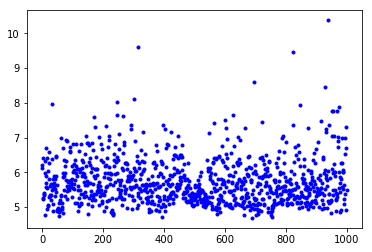

In [14]:
plt.plot(submission,"b.")